In [2]:
!kaggle datasets download -d parulpandey/palmer-archipelago-antarctica-penguin-data

Dataset URL: https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data
License(s): CC0-1.0
palmer-archipelago-antarctica-penguin-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
import zipfile
import os
import sqlite3
import pandas as pd
from data_loader import load_data_csv
from data_processor import data_discribe, data_fill_freq
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [4]:
with zipfile.ZipFile('palmer-archipelago-antarctica-penguin-data.zip', 'r') as zip_ref:
    zip_ref.extractall('palmer-archipelago-antarctica-penguin-data')

print(os.listdir('palmer-archipelago-antarctica-penguin-data'))

['penguins_lter.csv', 'penguins_size.csv']


In [5]:
df = load_data_csv('palmer-archipelago-antarctica-penguin-data\\penguins_size.csv')

if df is not None:
    print('--- Данные загружены ---')
    print(data_discribe(df))

    df_filled = data_fill_freq(df)
    print("--- Пропуски заполнены ---")
    print(data_discribe(df_filled))

Файл успешно загружен
--- Данные загружены ---
       species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
count      344     344        342.000000       342.000000         342.000000   
unique       3       3               NaN              NaN                NaN   
top     Adelie  Biscoe               NaN              NaN                NaN   
freq       152     168               NaN              NaN                NaN   
mean       NaN     NaN         43.921930        17.151170         200.915205   
std        NaN     NaN          5.459584         1.974793          14.061714   
min        NaN     NaN         32.100000        13.100000         172.000000   
25%        NaN     NaN         39.225000        15.600000         190.000000   
50%        NaN     NaN         44.450000        17.300000         197.000000   
75%        NaN     NaN         48.500000        18.700000         213.000000   
max        NaN     NaN         59.600000        21.500000         231.000

In [5]:
df_filled.columns = [c.lower().replace(' ', '_').replace('(', '').replace(')', '') for c in df_filled.columns]

conn = sqlite3.connect("penguins.db")
cursor = conn.cursor()

cursor.execute('''CREATE TABLE IF NOT EXISTS size (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    species TEXT,
    island TEXT,
    sex TEXT,
    culmen_length_mm REAL,
    culmen_depth_mm REAL,
    flipper_length_mm REAL,
    body_mass_g REAL,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)''')

df_filled.to_sql('size', conn, if_exists='append', index=False)

conn.commit()

cursor.execute("DELETE FROM size WHERE sex = '.'")
conn.commit()

print(f'Ready!Данные из {len(df_filled)} строк загружены в файл penguins.db в таблицу size')

cursor.execute("SELECT * FROM size LIMIT 3")
print(cursor.fetchall())

conn.close()

Ready!Данные из 344 строк загружены в файл penguins.db в таблицу size
[(1, 'Adelie', 'Torgersen', 'MALE', 39.1, 18.7, 181.0, 3750.0, '2026-02-19 19:32:56'), (2, 'Adelie', 'Torgersen', 'FEMALE', 39.5, 17.4, 186.0, 3800.0, '2026-02-19 19:32:56'), (3, 'Adelie', 'Torgersen', 'FEMALE', 40.3, 18.0, 195.0, 3250.0, '2026-02-19 19:32:56')]


In [14]:
import sqlite3
from tabulate import tabulate

def show(title, headers, query, limit=10):
    cursor.execute(query)
    rows = cursor.fetchall()
    
    print(f"\n### {title}")
    print(f"Всего найдено: {len(rows)} записей")
    
    if len(rows) > limit:
        preview_rows = rows[:3] + [["...", "...", "...", "..."]] + rows[-3:]
        print(tabulate(preview_rows, headers=headers, tablefmt="github", floatfmt=".1f"))
        print(f"*Отображено начало и конец, так как записей слишком много.*")
    else:
        print(tabulate(rows, headers=headers, tablefmt="github", floatfmt=".1f"))

conn = sqlite3.connect("penguins.db")
cursor = conn.cursor()

# 1. Пингвины с острова Torgersen > 4500г
show("Пингвины Torgersen > 4500г", 
     ["ID", "Вид", "Вес"], 
     "SELECT id, species, body_mass_g FROM size WHERE island = 'Torgersen' AND body_mass_g > 4500")

# 2. Топ-10 тяжеловесов
show("Топ-10 тяжеловесов", 
     ["ID", "Вид", "Остров", "Вес"], 
     "SELECT id, species, island, body_mass_g FROM size ORDER BY body_mass_g DESC LIMIT 10")

# 3. Вид Gentoo на острове Biscoe
show("Gentoo на Biscoe", 
     ["ID", "Вид", "Остров"], 
     "SELECT id, species, island FROM size WHERE species = 'Gentoo' AND island = 'Biscoe'")

# 4. Длина клюва (диапазон)
show("Клюв в диапазоне 44-49 мм", 
     ["ID", "Вид", "Клюв"], 
     "SELECT id, species, culmen_length_mm FROM size WHERE culmen_length_mm > 44 AND culmen_length_mm < 49")

# 5. Виды на букву 'A'
show("Виды на букву 'A'", 
     ["ID", "Вид"], 
     "SELECT id, species FROM size WHERE species LIKE 'A%'")

# 6. Все, кроме острова Dream
show("Все, кроме о. Dream", 
     ["ID", "Вид", "Остров"], 
     "SELECT id, species, island FROM size WHERE island <> 'Dream'")

# 7. Исключая Dream и Torgersen
show("Острова (кроме Dream и Torgersen)", 
     ["ID", "Вид", "Остров"], 
     "SELECT id, species, island FROM size WHERE island NOT IN ('Dream', 'Torgersen')")

# 8. Средние показатели (GROUP BY)
show("Средний вес и длина клюва", 
     ["Вид", "Ср. Клюв", "Ср. Вес"], 
     "SELECT species, AVG(culmen_length_mm), AVG(body_mass_g) FROM size GROUP BY species")

# 9. Перепись населения по островам
show("Распределение по островам", 
     ["Вид", "Остров", "Кол-во"], 
     "SELECT species, island, COUNT(*) FROM size GROUP BY island, species")

# 10. Размах крыльев по полу
show("Размах крыльев (Min/Max)", 
     ["Пол", "Мин", "Макс"], 
     "SELECT sex, MIN(flipper_length_mm), MAX(flipper_length_mm) FROM size WHERE sex IS NOT NULL GROUP BY sex")

# 11. Категории веса (CASE)
show("Категории веса (первые 10)", 
     ["Вид", "Вес", "Категория"], 
     "SELECT species, body_mass_g, CASE WHEN body_mass_g > 4500 THEN 'большой' ELSE 'маленький' END FROM size WHERE body_mass_g IS NOT NULL LIMIT 10")

# 12. Суммарный вес Adelie на Biscoe
show("Суммарный вес Adelie на Biscoe", 
     ["Вид", "Остров", "Общий вес"], 
     "SELECT species, island, SUM(body_mass_g) FROM size WHERE island = 'Biscoe' AND species = 'Adelie'")

# 13. Виды тяжелее 4000г (HAVING)
show("Виды со средним весом > 4000г", 
     ["Вид", "Ср. Вес"], 
     "SELECT species, AVG(body_mass_g) FROM size GROUP BY species HAVING AVG(body_mass_g) > 4000")

# 14. Уникальные пары
show("Уникальные локации", 
     ["Вид", "Остров"], 
     "SELECT DISTINCT species, island FROM size")

conn.close()


### Пингвины Torgersen > 4500г
Всего найдено: 2 записей
|   ID | Вид    |    Вес |
|------|--------|--------|
|    8 | Adelie | 4675.0 |
|   82 | Adelie | 4700.0 |

### Топ-10 тяжеловесов
Всего найдено: 10 записей
|   ID | Вид    | Остров   |    Вес |
|------|--------|----------|--------|
|  238 | Gentoo | Biscoe   | 6300.0 |
|  254 | Gentoo | Biscoe   | 6050.0 |
|  298 | Gentoo | Biscoe   | 6000.0 |
|  338 | Gentoo | Biscoe   | 6000.0 |
|  300 | Gentoo | Biscoe   | 5950.0 |
|  332 | Gentoo | Biscoe   | 5950.0 |
|  234 | Gentoo | Biscoe   | 5850.0 |
|  236 | Gentoo | Biscoe   | 5850.0 |
|  336 | Gentoo | Biscoe   | 5850.0 |
|  288 | Gentoo | Biscoe   | 5800.0 |

### Gentoo на Biscoe
Всего найдено: 123 записей
| ID   | Вид    | Остров   |
|------|--------|----------|
| 221  | Gentoo | Biscoe   |
| 222  | Gentoo | Biscoe   |
| 223  | Gentoo | Biscoe   |
| ...  | ...    | ...      |
| 342  | Gentoo | Biscoe   |
| 343  | Gentoo | Biscoe   |
| 344  | Gentoo | Biscoe   |
*Отображено начало 

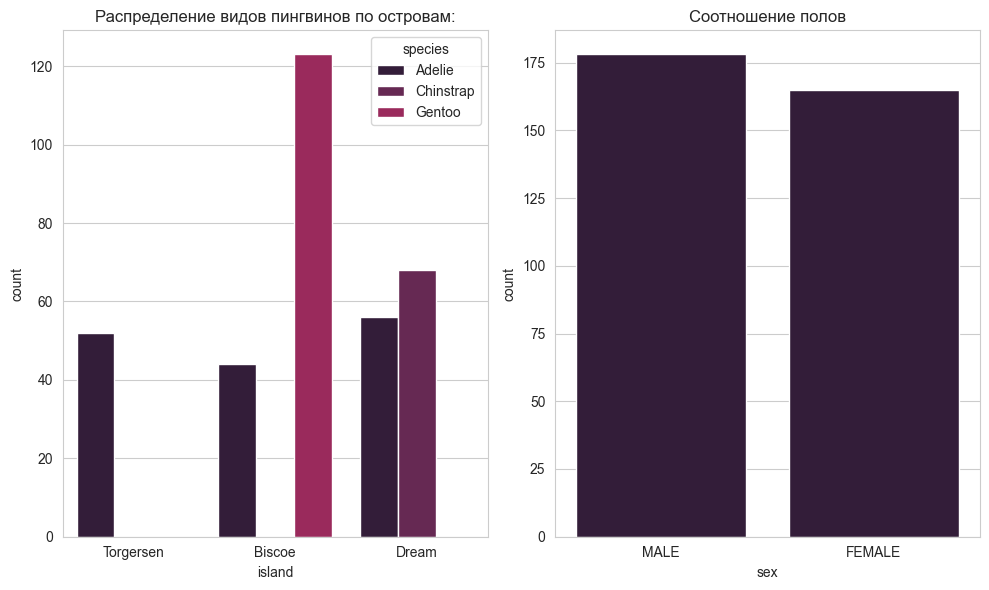

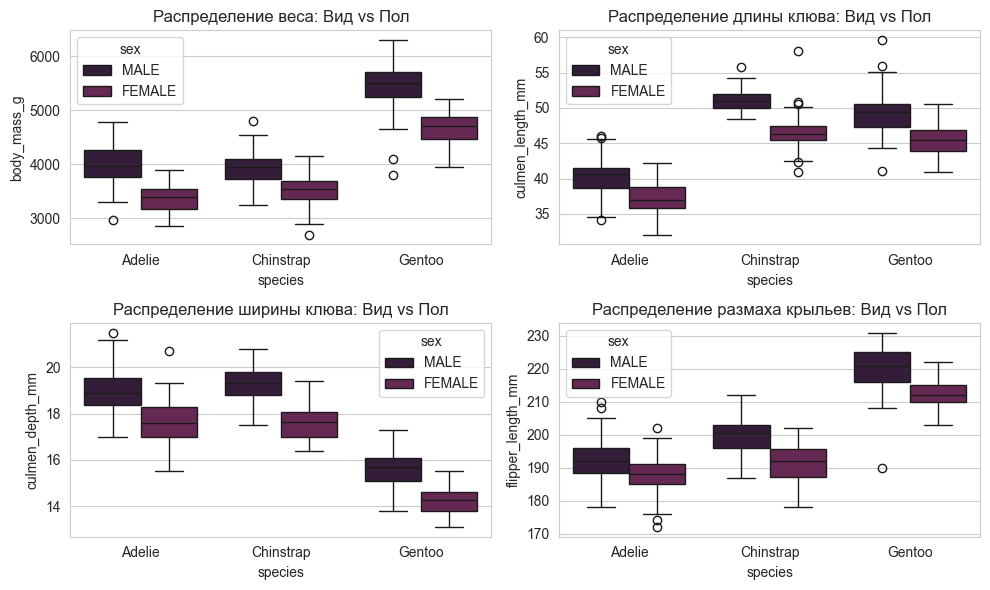

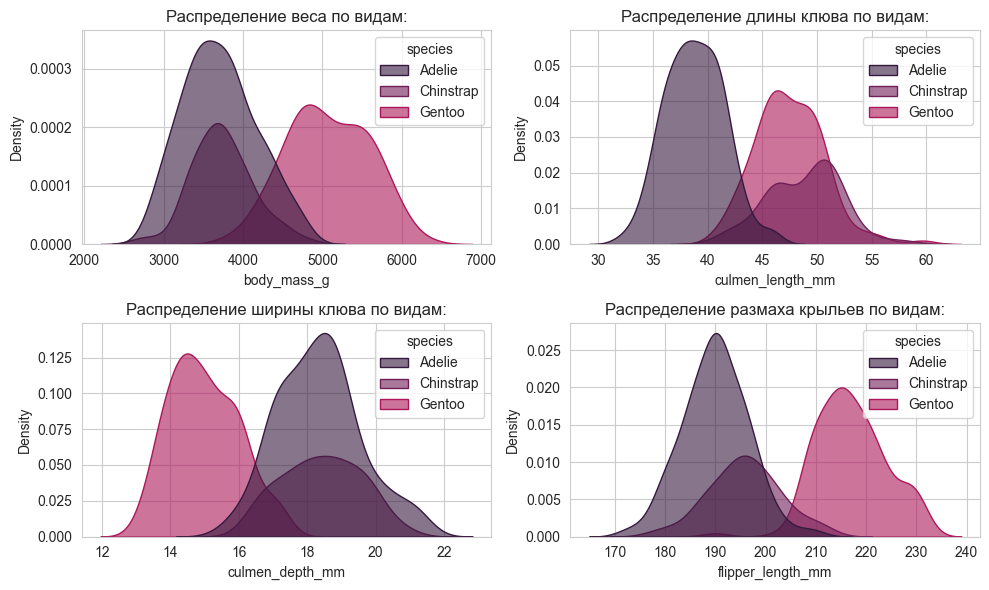

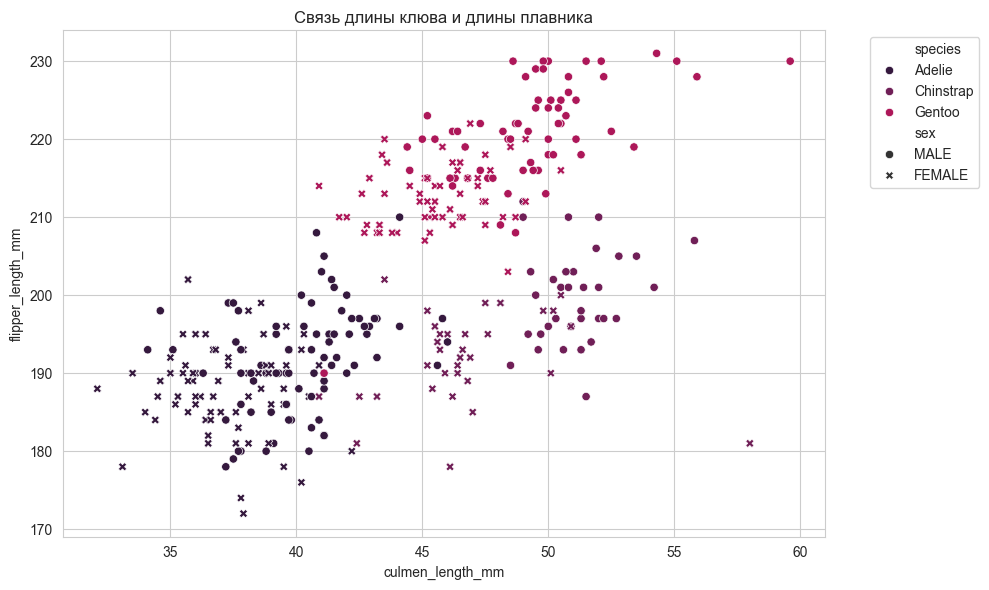

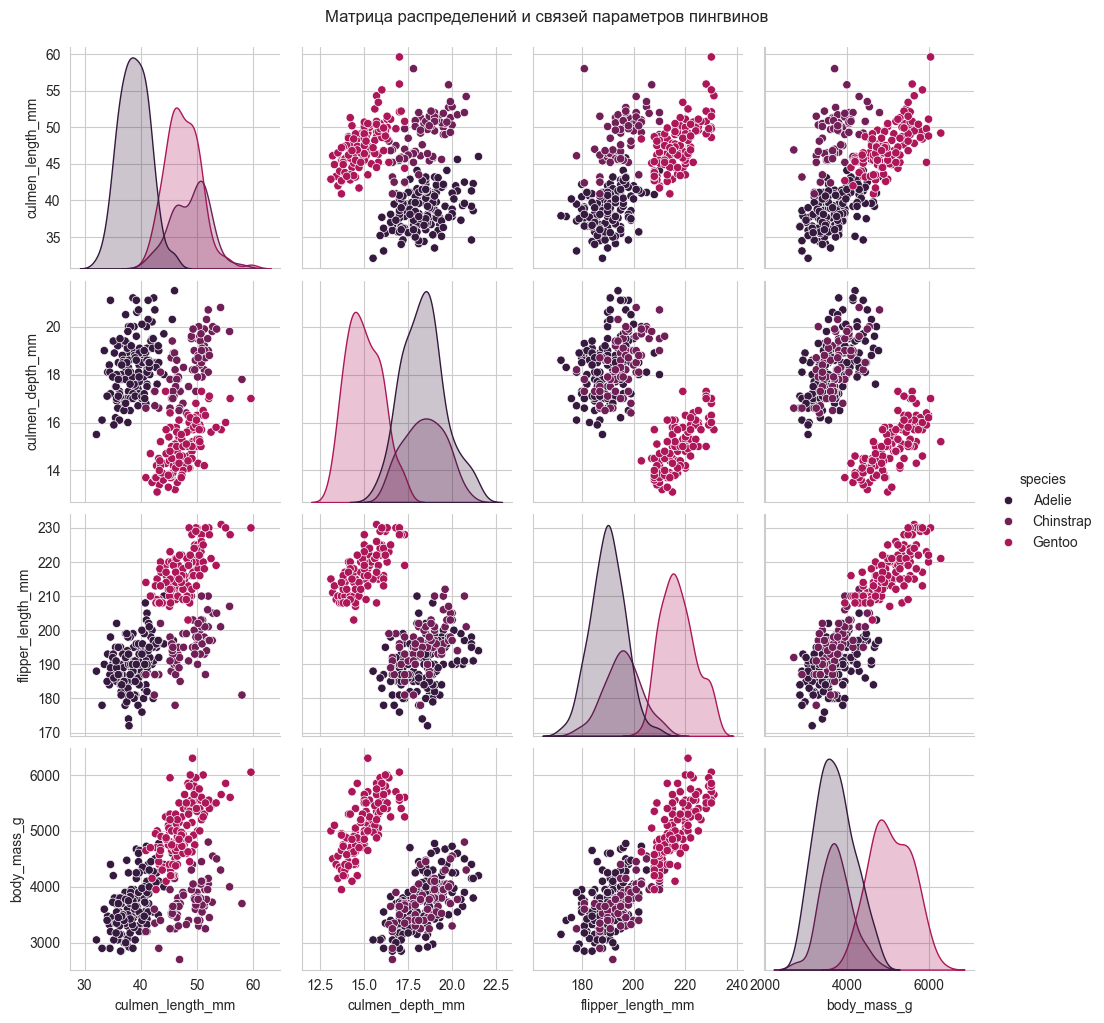

In [12]:
conn = sqlite3.connect("penguins.db")

df_viz = pd.read_sql("SELECT * FROM size", conn)
conn.close()

sns.set_style("whitegrid")
sns.set_palette("rocket")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.countplot(data=df_viz, x='island', hue='species', ax=axes[0])
axes[0].set_title("Распределение видов пингвинов по островам:")

sns.countplot(data=df_viz, x='sex', ax=axes[1])
axes[1].set_title("Соотношение полов")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

sns.boxplot(data=df_viz, x='species', y='body_mass_g', hue="sex", ax=axes[0, 0])
axes[0, 0].set_title("Распределение веса: Вид vs Пол")

sns.boxplot(data=df_viz, x='species', y='culmen_length_mm', hue="sex", ax=axes[0, 1])
axes[0, 1].set_title("Распределение длины клюва: Вид vs Пол")

sns.boxplot(data=df_viz, x='species', y='culmen_depth_mm', hue="sex", ax=axes[1, 0])
axes[1, 0].set_title("Распределение ширины клюва: Вид vs Пол")

sns.boxplot(data=df_viz, x='species', y='flipper_length_mm', hue="sex", ax=axes[1, 1])
axes[1, 1].set_title("Распределение размаха крыльев: Вид vs Пол")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

sns.kdeplot(data=df_viz, x='body_mass_g', hue="species", ax=axes[0, 0], fill=True, alpha=0.6)
axes[0, 0].set_title("Распределение веса по видам:")

sns.kdeplot(data=df_viz, x='culmen_length_mm', hue="species", ax=axes[0, 1], fill=True, alpha=0.6)
axes[0, 1].set_title("Распределение длины клюва по видам:")

sns.kdeplot(data=df_viz, x='culmen_depth_mm', hue="species", ax=axes[1, 0], fill=True, alpha=0.6)
axes[1, 0].set_title("Распределение ширины клюва по видам:")

sns.kdeplot(data=df_viz, x='flipper_length_mm', hue="species", ax=axes[1, 1], fill=True, alpha=0.6)
axes[1, 1].set_title("Распределение размаха крыльев по видам:")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_viz, x='culmen_length_mm', y='flipper_length_mm', hue='species', style='sex')
plt.title('Связь длины клюва и длины плавника')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

cols_to_plot = ['species', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
pair_grid = sns.pairplot(df[cols_to_plot], hue='species', diag_kind='kde')
pair_grid.fig.suptitle("Матрица распределений и связей параметров пингвинов", y=1.02)
plt.show()
